In [19]:
import scipy
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
from itertools import combinations
from scipy.spatial import distance
from scipy.spatial.distance import squareform, pdist
from scipy.cluster.hierarchy import linkage, dendrogram, cut_tree, fcluster, cophenet






In [20]:
def clean_data(lpdata):

    def drop_and_report(df, cols_to_drop, label):
        cols_to_drop = [c for c in cols_to_drop if c in df.columns]
        print("==============================================================")
        print(f"Number of columns removed containing '{label}': {len(cols_to_drop)}")
        if cols_to_drop:
            print(f"Columns removed containing '{label}': {', '.join(cols_to_drop)}")
        else:
            print("(none)")
        return df.drop(columns=cols_to_drop)

    def contains(df, substring, ignore_case):
        if ignore_case:
            s = substring.lower()
            return [c for c in df.columns if s in c.lower()]
        else:
            return [c for c in df.columns if substring in c]

    print("Original data size:", lpdata.shape)

    metadata_columns = [c for c in lpdata.columns if "metadata" in c.lower()]
    lpvalues = lpdata.drop(columns=metadata_columns)
    print("Data size after removing metadata:", lpvalues.shape)

    lpvalues = drop_and_report(lpvalues, contains(lpvalues, "RWC", True), "RWC")
    print("Current data size:", lpvalues.shape)

    lpvalues = drop_and_report(lpvalues, contains(lpvalues, "costes", True), "costes")
    print("Current data size:", lpvalues.shape)

    lpvalues = lpvalues.apply(pd.to_numeric, errors="coerce")

    std_series = lpvalues.std(numeric_only=True)
    zero_sd_cols = std_series[std_series == 0].index.tolist()
    print("==============================================================")
    print("Count of columns removed due to 0 std dev:", len(zero_sd_cols))
    if zero_sd_cols:
        print("Columns removed:", ", ".join(zero_sd_cols))
    else:
        print("(none)")
    lpvalues = lpvalues.drop(columns=zero_sd_cols)
    print("Current data size:", lpvalues.shape)

    lpvalues = drop_and_report(lpvalues, contains(lpvalues, "Image_", True), "Image_")
    print("Current data size:", lpvalues.shape)

    lpvalues = drop_and_report(lpvalues, contains(lpvalues, "BoundingBox", True), "BoundingBox")
    print("Current data size:", lpvalues.shape)

    lpvalues = drop_and_report(lpvalues, contains(lpvalues, "X_", False), "X_")
    print("Current data size:", lpvalues.shape)

    lpvalues = drop_and_report(lpvalues, contains(lpvalues, "Y_", False), "Y_")
    print("Current data size:", lpvalues.shape)

    lpvalues = drop_and_report(lpvalues, contains(lpvalues, "_X", False), "_X")
    print("Current data size:", lpvalues.shape)

    lpvalues = drop_and_report(lpvalues, contains(lpvalues, "_Y", False), "_Y")
    print("Current data size:", lpvalues.shape)

    lpvalues = drop_and_report(lpvalues, contains(lpvalues, "Z_", False), "Z_")
    print("Current data size:", lpvalues.shape)

    lpvalues = drop_and_report(lpvalues, contains(lpvalues, "Manders_", False), "Manders_")
    print("Current data size:", lpvalues.shape)

    lpvalues = drop_and_report(lpvalues, contains(lpvalues, "_Manders", False), "_Manders")
    print("Current data size:", lpvalues.shape)

    lpvalues.replace([np.inf, -np.inf], np.nan, inplace=True)

    all_nan_cols = [c for c in lpvalues.columns if lpvalues[c].isna().all()]
    lpvalues = drop_and_report(lpvalues, all_nan_cols, "all-NaN")
    print("Current data size:", lpvalues.shape)

    sorted_df = lpvalues.sort_index(axis=1)
    print("==============================================================")
    print("Data size after cleaning:", sorted_df.shape)
    return sorted_df




def get_sq_cormatrix(df, plotfile=None):
    # compute R²
    cm = df.corr()
    print(f"Minimum raw corr: {cm.values.min():.6f}")
    print(f"Maximum raw corr: {cm.values.max():.6f}")
    cm_clipped = cm.clip(lower=-1, upper=1)
    r2 = cm_clipped**2
    print(f"Minimum R²: {r2.values.min():.6f}")
    print(f"Maximum R²: {r2.values.max():.6f}")

    plt.figure(figsize=(6, 6))
    im = plt.imshow(
        r2.to_numpy(),
        interpolation='nearest',
        aspect='auto',
        cmap='RdBu_r',    
        vmin=0, vmax=1
    )
    plt.axis('off')     
    cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
    cbar.set_label('R²', rotation=270, labelpad=15)
    if plotfile:
        plt.savefig(plotfile, bbox_inches='tight')
    plt.show()

    return r2

def get_optimum_clusters(R2, linkage_matrix, dendofile):
    cormat = R2.to_numpy()
    cluster_distance = cophenet(linkage_matrix)
    print(type(cluster_distance))

    flag = False
    k1 = 0
    cluster1 = None

    for k in np.arange(0, cluster_distance.max(), 0.001):
        cluster = fcluster(linkage_matrix, t=k, criterion='distance')
        cdf=pd.DataFrame(list(zip(R2.columns.to_list(),cluster)),columns=["feature","cluster"])
        grouped_lp = cdf.groupby('cluster')

        for group,indices in grouped_lp.groups.items():
            row_index = indices.values
            col_index = indices.values
            select = cormat[row_index][:, col_index]
            mincor = np.min(select)
            if mincor<0.9:
                print("uh oh, intracluster correlation dropped at cophenetic distance k ",k)
                flag=1
                break
        if flag==1:
            print("best clusters are ",len(np.unique(cluster1))," at k ",k1)
            break
        cluster1=cluster
        k1=k
        
    plt.figure()
    dendrogram(linkage_matrix)
    plt.axhline(y=k1) 
    plt.savefig(dendofile,bbox_inches="tight")
    plt.show()
    return cluster1


## Test

# New Categorization

In [21]:
output_path = "/Users/cho/Documents/cellprofiler/downstream/9p21/072225/fr/"
os.makedirs(output_path, exist_ok=True)
filtered_path = "/Users/cho/Documents/cellprofiler/downstream/9p21/072225/fr/filter/"
os.makedirs(filtered_path, exist_ok=True)

lpfile = '/Users/cho/Documents/cellprofiler/downstream/9p21/LP/profileWithMetadata/raw_df.csv'
lpdf = pd.read_csv(lpfile)

In [22]:
print(lpdf.shape)

plate1 = '2024_0528_LP_FAA_PRIMARY_SMC_PLATE1_T13_52_10'
plate2 = '2024_0528_LP_FAA_PRIMARY_SMC_PLATE2_T14_38_35'

wells_to_remove_plate1 = {"B03", "B04", "B05", "D02", "D03", "E03", "E04", "F03", "F05"}
wells_to_remove_plate2 = {"B04", "C04", "C05", "D04", "E03", "E04", "F02", "F04", "F05"}

mask_remove = (
    (lpdf['Metadata_cell_type'] == 'primary smc') &
    (
        (
            (lpdf['Metadata_Plate'] == plate1) &
            (lpdf['Metadata_Well'].isin(wells_to_remove_plate1))
        ) |
        (
            (lpdf['Metadata_Plate'] == plate2) &
            (lpdf['Metadata_Well'].isin(wells_to_remove_plate2))
        )
    )
)

lpdf = lpdf[~mask_remove]
print(lpdf.shape)

cfb_mask = lpdf['Metadata_cell_type'] == 'primary cfb'

to_remove = lpdf[cfb_mask & (lpdf['Metadata_Object_Count'] < 9000)]

print(to_remove[['Metadata_Plate', 'Metadata_Well', 'Metadata_stimulation', 'Metadata_treatment']])
print("Before filtering:", lpdf.shape)

lpdf = lpdf[~cfb_mask | (lpdf['Metadata_Object_Count'] >= 9000)]

print("After filtering:", lpdf.shape)


(220, 3259)
(202, 3259)
                                   Metadata_Plate Metadata_Well  \
85  2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14           E07   

   Metadata_stimulation Metadata_treatment  
85                 tgfb             siMTAP  
Before filtering: (202, 3259)
After filtering: (201, 3259)


In [23]:
num_columns_with_na = lpdf.isna().any().sum()
print(f"Number of columns with at least one NaN: {num_columns_with_na}")


Number of columns with at least one NaN: 0


In [24]:
metadata_columns = lpdf.filter(like="Metadata", axis=1).columns
feature_columns = lpdf.columns[~lpdf.columns.isin(metadata_columns)]

features_df = pd.DataFrame({'features': feature_columns})

reduced_data_list = []
cluster_info_list = []

In [25]:
output_path

'/Users/cho/Documents/cellprofiler/downstream/9p21/072225/fr/'

In [26]:
dendofile = output_path+"_dendo.pdf"
clusterfile = output_path+"_clusters.csv"
reducedfile=filtered_path+"data_" + ".csv"


In [27]:

sub_lpdf = lpdf

sub_lpdf = sub_lpdf[
    (sub_lpdf['Metadata_treatment'] == 'nontargeting control') |
    (sub_lpdf['Metadata_treatment'] == 'siMTAP')
]
sub_lpdf = sub_lpdf[
    (sub_lpdf['Metadata_Plate'] == '2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14') |

     (sub_lpdf['Metadata_Plate'] == '2024_0528_LP_FAA_PRIMARY_SMC_PLATE2_T14_38_35')
]



meta_lpdf =sub_lpdf.filter(regex=f'^(Meta)')
print("lp data:",sub_lpdf.shape)


lp data: (36, 3259)


In [28]:
sub_lpdf

,Metadata_cell_type,Metadata_treatment,Metadata_stimulation,Metadata_Plate,Metadata_Well,Metadata_Site_Count,Metadata_Object_Count,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,...,Nuclei_Texture_Variance_Mito_10_02_256,Nuclei_Texture_Variance_Mito_10_03_256,Nuclei_Texture_Variance_Mito_20_00_256,Nuclei_Texture_Variance_Mito_20_01_256,Nuclei_Texture_Variance_Mito_20_02_256,Nuclei_Texture_Variance_Mito_20_03_256,Nuclei_Texture_Variance_Mito_5_00_256,Nuclei_Texture_Variance_Mito_5_01_256,Nuclei_Texture_Variance_Mito_5_02_256,Nuclei_Texture_Variance_Mito_5_03_256
70,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D02,25,13810,1521.0,3222.0,572.0,...,12.447158,13.232077,0,0,0,0,12.739345,12.917640,12.728038,13.336815
71,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D03,25,13952,1576.0,3266.0,572.0,...,14.999482,15.351203,0,0,0,0,15.016857,15.579158,15.024759,15.191407
72,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D04,25,14127,1519.0,3234.0,574.0,...,12.805373,13.208821,0,0,0,0,13.213456,13.770089,13.226635,13.353027
73,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D05,25,14159,1549.0,3186.0,572.0,...,16.230395,16.986610,0,0,0,0,16.318040,16.764571,16.235777,16.729792
74,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D06,25,13544,1517.0,3087.0,574.0,...,12.579679,12.957525,0,0,0,0,12.922356,13.307054,12.874855,13.089093
75,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D07,25,13178,1627.0,3564.0,569.0,...,8.042191,8.151305,0,0,0,0,8.111330,8.210045,8.120075,8.215816
76,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D08,25,14211,1601.0,3416.0,573.0,...,10.344121,10.369416,0,0,0,0,10.232697,10.311377,10.136028,10.245470
77,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D09,25,14478,1553.0,3290.0,581.0,...,9.463316,9.661595,0,0,0,0,9.384163,9.440156,9.362269,9.532318
78,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D10,25,14171,1573.0,3381.0,576.0,...,10.690440,10.806051,0,0,0,0,10.643098,10.783571,10.633250,10.687536
79,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D11,25,14121,1589.0,3481.0,580.0,...,12.196101,12.431865,0,0,0,0,12.261504,12.410591,12.298729,12.350618


In [29]:
metadata_mask = sub_lpdf.columns.str.contains("metadata", case=False)
metadata_df   = sub_lpdf.loc[:, metadata_mask]
metadata_df.head()

,Metadata_cell_type,Metadata_treatment,Metadata_stimulation,Metadata_Plate,Metadata_Well,Metadata_Site_Count,Metadata_Object_Count
70,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D02,25,13810
71,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D03,25,13952
72,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D04,25,14127
73,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D05,25,14159
74,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D06,25,13544


In [30]:
sub_lpdf = clean_data(sub_lpdf)


Original data size: (36, 3259)
Data size after removing metadata: (36, 3252)
Number of columns removed containing 'RWC': 60
Columns removed containing 'RWC': Cells_Correlation_RWC_AGP_BODIPYRNA, Cells_Correlation_RWC_AGP_DNA, Cells_Correlation_RWC_AGP_Mito, Cells_Correlation_RWC_BODIPYRNA_AGP, Cells_Correlation_RWC_BODIPYRNA_DNA, Cells_Correlation_RWC_BODIPYRNA_Mito, Cells_Correlation_RWC_DNA_AGP, Cells_Correlation_RWC_DNA_BODIPYRNA, Cells_Correlation_RWC_DNA_Mito, Cells_Correlation_RWC_Mito_AGP, Cells_Correlation_RWC_Mito_BODIPYRNA, Cells_Correlation_RWC_Mito_DNA, Cells_Mean_LargeBODIPYObjects_Correlation_RWC_AGP_BODIPYRNA, Cells_Mean_LargeBODIPYObjects_Correlation_RWC_AGP_DNA, Cells_Mean_LargeBODIPYObjects_Correlation_RWC_AGP_Mito, Cells_Mean_LargeBODIPYObjects_Correlation_RWC_BODIPYRNA_AGP, Cells_Mean_LargeBODIPYObjects_Correlation_RWC_BODIPYRNA_DNA, Cells_Mean_LargeBODIPYObjects_Correlation_RWC_BODIPYRNA_Mito, Cells_Mean_LargeBODIPYObjects_Correlation_RWC_DNA_AGP, Cells_Mean_LargeB

In [32]:
print(sub_lpdf.shape)
sub_lpdf.head()


(36, 2715)


,Cells_AreaShape_Area,Cells_AreaShape_Compactness,Cells_AreaShape_ConvexArea,Cells_AreaShape_Eccentricity,Cells_AreaShape_EquivalentDiameter,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,Cells_AreaShape_MaxFeretDiameter,Cells_AreaShape_MaximumRadius,...,Nuclei_Texture_Variance_DNA_5_02_256,Nuclei_Texture_Variance_DNA_5_03_256,Nuclei_Texture_Variance_Mito_10_00_256,Nuclei_Texture_Variance_Mito_10_01_256,Nuclei_Texture_Variance_Mito_10_02_256,Nuclei_Texture_Variance_Mito_10_03_256,Nuclei_Texture_Variance_Mito_5_00_256,Nuclei_Texture_Variance_Mito_5_01_256,Nuclei_Texture_Variance_Mito_5_02_256,Nuclei_Texture_Variance_Mito_5_03_256
70,1521.0,2.708554,1979.0,0.880496,44.006788,0.488595,0.369201,69.468776,73.824115,13.453624,...,36.873136,39.691346,12.657758,12.574727,12.447158,13.232077,12.739345,12.917640,12.728038,13.336815
71,1576.0,2.715272,2050.0,0.881050,44.795374,0.496498,0.368287,70.937158,75.451971,13.892444,...,43.440884,45.303748,14.895011,16.015828,14.999482,15.351203,15.016857,15.579158,15.024759,15.191407
72,1519.0,2.687595,1978.0,0.879625,43.977845,0.487993,0.372080,69.533055,74.027022,13.601471,...,37.997559,39.715518,13.480022,14.005214,12.805373,13.208821,13.213456,13.770089,13.226635,13.353027
73,1549.0,2.721165,2012.0,0.885548,44.409999,0.497947,0.367490,70.562289,75.153177,13.453624,...,42.718904,44.896919,16.460850,16.933303,16.230395,16.986610,16.318040,16.764571,16.235777,16.729792
74,1517.0,2.707577,1974.0,0.876022,43.948884,0.502919,0.369334,68.854681,73.167616,13.601471,...,28.778459,30.062222,12.930724,13.300431,12.579679,12.957525,12.922356,13.307054,12.874855,13.089093


In [33]:
sub_lpdf_with_metadata = pd.concat([metadata_df, sub_lpdf], axis=1)
sub_lpdf_with_metadata.head()

,Metadata_cell_type,Metadata_treatment,Metadata_stimulation,Metadata_Plate,Metadata_Well,Metadata_Site_Count,Metadata_Object_Count,Cells_AreaShape_Area,Cells_AreaShape_Compactness,Cells_AreaShape_ConvexArea,...,Nuclei_Texture_Variance_DNA_5_02_256,Nuclei_Texture_Variance_DNA_5_03_256,Nuclei_Texture_Variance_Mito_10_00_256,Nuclei_Texture_Variance_Mito_10_01_256,Nuclei_Texture_Variance_Mito_10_02_256,Nuclei_Texture_Variance_Mito_10_03_256,Nuclei_Texture_Variance_Mito_5_00_256,Nuclei_Texture_Variance_Mito_5_01_256,Nuclei_Texture_Variance_Mito_5_02_256,Nuclei_Texture_Variance_Mito_5_03_256
70,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D02,25,13810,1521.0,2.708554,1979.0,...,36.873136,39.691346,12.657758,12.574727,12.447158,13.232077,12.739345,12.917640,12.728038,13.336815
71,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D03,25,13952,1576.0,2.715272,2050.0,...,43.440884,45.303748,14.895011,16.015828,14.999482,15.351203,15.016857,15.579158,15.024759,15.191407
72,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D04,25,14127,1519.0,2.687595,1978.0,...,37.997559,39.715518,13.480022,14.005214,12.805373,13.208821,13.213456,13.770089,13.226635,13.353027
73,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D05,25,14159,1549.0,2.721165,2012.0,...,42.718904,44.896919,16.460850,16.933303,16.230395,16.986610,16.318040,16.764571,16.235777,16.729792
74,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D06,25,13544,1517.0,2.707577,1974.0,...,28.778459,30.062222,12.930724,13.300431,12.579679,12.957525,12.922356,13.307054,12.874855,13.089093


In [34]:
sub_lpdf_with_metadata = sub_lpdf_with_metadata[
    (sub_lpdf_with_metadata['Metadata_treatment'] == 'nontargeting control') |
    (sub_lpdf_with_metadata['Metadata_treatment'] == 'siMTAP')
]
sub_lpdf_with_metadata = sub_lpdf_with_metadata[
    (sub_lpdf_with_metadata['Metadata_Plate'] == '2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14') |
    (sub_lpdf_with_metadata['Metadata_Plate'] == '2024_0528_LP_FAA_PRIMARY_SMC_PLATE2_T14_38_35')
]


In [35]:
sub_lpdf_with_metadata

,Metadata_cell_type,Metadata_treatment,Metadata_stimulation,Metadata_Plate,Metadata_Well,Metadata_Site_Count,Metadata_Object_Count,Cells_AreaShape_Area,Cells_AreaShape_Compactness,Cells_AreaShape_ConvexArea,...,Nuclei_Texture_Variance_DNA_5_02_256,Nuclei_Texture_Variance_DNA_5_03_256,Nuclei_Texture_Variance_Mito_10_00_256,Nuclei_Texture_Variance_Mito_10_01_256,Nuclei_Texture_Variance_Mito_10_02_256,Nuclei_Texture_Variance_Mito_10_03_256,Nuclei_Texture_Variance_Mito_5_00_256,Nuclei_Texture_Variance_Mito_5_01_256,Nuclei_Texture_Variance_Mito_5_02_256,Nuclei_Texture_Variance_Mito_5_03_256
70,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D02,25,13810,1521.0,2.708554,1979.0,...,36.873136,39.691346,12.657758,12.574727,12.447158,13.232077,12.739345,12.917640,12.728038,13.336815
71,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D03,25,13952,1576.0,2.715272,2050.0,...,43.440884,45.303748,14.895011,16.015828,14.999482,15.351203,15.016857,15.579158,15.024759,15.191407
72,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D04,25,14127,1519.0,2.687595,1978.0,...,37.997559,39.715518,13.480022,14.005214,12.805373,13.208821,13.213456,13.770089,13.226635,13.353027
73,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D05,25,14159,1549.0,2.721165,2012.0,...,42.718904,44.896919,16.460850,16.933303,16.230395,16.986610,16.318040,16.764571,16.235777,16.729792
74,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D06,25,13544,1517.0,2.707577,1974.0,...,28.778459,30.062222,12.930724,13.300431,12.579679,12.957525,12.922356,13.307054,12.874855,13.089093
75,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D07,25,13178,1627.0,2.792859,2131.0,...,24.984574,26.001358,8.055260,8.256331,8.042191,8.151305,8.111330,8.210045,8.120075,8.215816
76,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D08,25,14211,1601.0,2.821426,2097.0,...,33.698688,34.978733,10.030257,10.507346,10.344121,10.369416,10.232697,10.311377,10.136028,10.245470
77,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D09,25,14478,1553.0,2.771048,2028.0,...,28.650010,30.171430,9.413681,9.576291,9.463316,9.661595,9.384163,9.440156,9.362269,9.532318
78,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D10,25,14171,1573.0,2.804926,2065.0,...,25.396413,26.425180,10.683855,11.056848,10.690440,10.806051,10.643098,10.783571,10.633250,10.687536
79,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D11,25,14121,1589.0,2.881622,2107.0,...,22.772511,23.757208,12.507653,12.732274,12.196101,12.431865,12.261504,12.410591,12.298729,12.350618


Minimum raw corr: -0.999813
Maximum raw corr: 1.000000
Minimum R²: 0.000000
Maximum R²: 1.000000


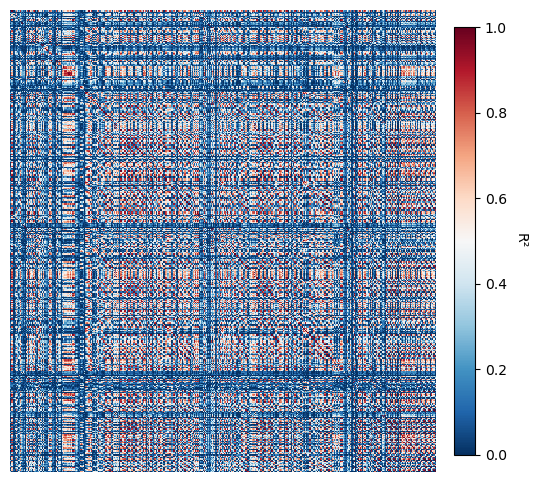

In [36]:
#get correlation matrix
R2 = get_sq_cormatrix(sub_lpdf)

cormat = R2.to_numpy()

In [37]:
dm = 1 - cormat 
dm = np.concatenate([row[i+1:] for i, row in enumerate(dm)])
linkage_matrix = linkage(dm, method='complete') 

In [38]:
linkage_matrix

array([[2.000e+00, 1.184e+03, 0.000e+00, 2.000e+00],
       [1.200e+01, 1.194e+03, 0.000e+00, 2.000e+00],
       [4.970e+02, 4.980e+02, 0.000e+00, 2.000e+00],
       ...,
       [5.420e+03, 5.421e+03, 1.000e+00, 6.270e+02],
       [5.423e+03, 5.426e+03, 1.000e+00, 1.104e+03],
       [5.425e+03, 5.427e+03, 1.000e+00, 2.715e+03]])

<class 'numpy.ndarray'>
uh oh, intracluster correlation dropped at cophenetic distance k  0.101
best clusters are  850  at k  0.1


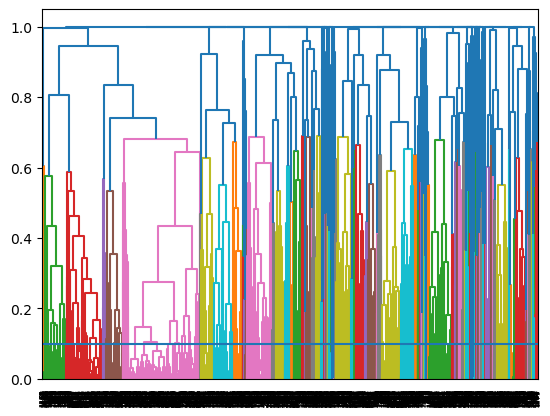

In [39]:
cluster = get_optimum_clusters(R2,linkage_matrix,dendofile)


In [40]:
df_cluster=pd.DataFrame(list(zip(R2.columns.to_list(),cluster)),columns=["Feature","clusternum"])
df_cluster['cluster_name'] = df_cluster.groupby('clusternum')['Feature'].transform('first')
print("done")

done


In [41]:
lpdata =sub_lpdf.T
lpdata.reset_index(inplace=True)
lpdata.rename(columns={'index': 'Feature'}, inplace=True)
print("done")

done


In [42]:
lpdata

,Feature,70,71,72,73,74,75,76,77,78,...,189,190,191,193,194,195,196,197,198,199
0,Cells_AreaShape_Area,1521.000000,1576.000000,1519.000000,1549.000000,1517.000000,1627.000000,1601.000000,1553.000000,1573.000000,...,3240.000000,3760.500000,3756.500000,3518.000000,3702.000000,3456.000000,3563.500000,3700.000000,3700.000000,3858.000000
1,Cells_AreaShape_Compactness,2.708554,2.715272,2.687595,2.721165,2.707577,2.792859,2.821426,2.771048,2.804926,...,3.151893,3.199777,3.247932,3.126051,3.133801,3.195055,3.138994,3.199171,3.208734,3.209064
2,Cells_AreaShape_ConvexArea,1979.000000,2050.000000,1978.000000,2012.000000,1974.000000,2131.000000,2097.000000,2028.000000,2065.000000,...,4303.500000,5078.500000,5149.500000,4781.000000,4935.000000,4662.000000,4769.500000,4919.000000,4969.000000,5221.000000
3,Cells_AreaShape_Eccentricity,0.880496,0.881050,0.879625,0.885548,0.876022,0.873890,0.881630,0.873744,0.878682,...,0.901698,0.883976,0.890235,0.879327,0.886881,0.895424,0.888076,0.883699,0.895310,0.886693
4,Cells_AreaShape_EquivalentDiameter,44.006788,44.795374,43.977845,44.409999,43.948884,45.514401,45.149269,44.467303,44.752718,...,64.228467,69.195500,69.158689,66.927249,68.655173,66.334876,67.358660,68.636625,68.636625,70.086790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2710,Nuclei_Texture_Variance_Mito_10_03_256,13.232077,15.351203,13.208821,16.986610,12.957525,8.151305,10.369416,9.661595,10.806051,...,16.591773,17.118464,16.985993,17.993333,16.831417,19.412180,18.084056,17.962520,17.954065,15.611108
2711,Nuclei_Texture_Variance_Mito_5_00_256,12.739345,15.016857,13.213456,16.318040,12.922356,8.111330,10.232697,9.384163,10.643098,...,15.246387,15.945716,15.789176,16.961542,15.401291,18.556396,17.782042,17.222703,16.923365,15.124149
2712,Nuclei_Texture_Variance_Mito_5_01_256,12.917640,15.579158,13.770089,16.764571,13.307054,8.210045,10.311377,9.440156,10.783571,...,15.386280,16.147512,15.980064,17.109450,15.465346,18.644147,17.754218,17.394907,16.992647,14.999380
2713,Nuclei_Texture_Variance_Mito_5_02_256,12.728038,15.024759,13.226635,16.235777,12.874855,8.120075,10.136028,9.362269,10.633250,...,15.255842,16.097455,15.868665,16.965918,15.287717,18.577266,17.929785,17.178015,16.965521,15.070602


In [43]:
merged_df = pd.merge(df_cluster, lpdata, on='Feature', how='inner')
merged_df.head()

,Feature,clusternum,cluster_name,70,71,72,73,74,75,76,...,189,190,191,193,194,195,196,197,198,199
0,Cells_AreaShape_Area,106,Cells_AreaShape_Area,1521.000000,1576.000000,1519.000000,1549.000000,1517.000000,1627.000000,1601.000000,...,3240.000000,3760.500000,3756.500000,3518.000000,3702.000000,3456.000000,3563.500000,3700.000000,3700.000000,3858.000000
1,Cells_AreaShape_Compactness,16,Cells_AreaShape_Compactness,2.708554,2.715272,2.687595,2.721165,2.707577,2.792859,2.821426,...,3.151893,3.199777,3.247932,3.126051,3.133801,3.195055,3.138994,3.199171,3.208734,3.209064
2,Cells_AreaShape_ConvexArea,106,Cells_AreaShape_Area,1979.000000,2050.000000,1978.000000,2012.000000,1974.000000,2131.000000,2097.000000,...,4303.500000,5078.500000,5149.500000,4781.000000,4935.000000,4662.000000,4769.500000,4919.000000,4969.000000,5221.000000
3,Cells_AreaShape_Eccentricity,821,Cells_AreaShape_Eccentricity,0.880496,0.881050,0.879625,0.885548,0.876022,0.873890,0.881630,...,0.901698,0.883976,0.890235,0.879327,0.886881,0.895424,0.888076,0.883699,0.895310,0.886693
4,Cells_AreaShape_EquivalentDiameter,106,Cells_AreaShape_Area,44.006788,44.795374,43.977845,44.409999,43.948884,45.514401,45.149269,...,64.228467,69.195500,69.158689,66.927249,68.655173,66.334876,67.358660,68.636625,68.636625,70.086790


In [44]:
columns_to_convert = [col for col in merged_df.columns 
                     if col not in ['Feature', 'cluster_name', 'clusternum']]

merged_df[columns_to_convert] = merged_df[columns_to_convert].apply(
    pd.to_numeric, errors='coerce'  
)

In [45]:

median_df = merged_df.groupby('clusternum').median(numeric_only=True).reset_index()


In [46]:
print(merged_df.shape)
merged_df = merged_df[['clusternum', 'cluster_name']].drop_duplicates()
print(merged_df.shape)


(2715, 39)
(850, 2)


In [47]:
merged_df

,clusternum,cluster_name
0,106,Cells_AreaShape_Area
1,16,Cells_AreaShape_Compactness
3,821,Cells_AreaShape_Eccentricity
5,8,Cells_AreaShape_Extent
7,104,Cells_AreaShape_MajorAxisLength
...,...,...
2630,355,Nuclei_Texture_SumEntropy_BODIPYRNA_10_03_256
2660,663,Nuclei_Texture_SumVariance_BODIPYRNA_10_01_256
2662,356,Nuclei_Texture_SumVariance_BODIPYRNA_10_03_256
2668,14,Nuclei_Texture_SumVariance_DNA_10_01_256


In [48]:
df_reduced = pd.merge(merged_df,median_df,on='clusternum')
colnames=df_reduced.cluster_name.to_list()
df_reduced.drop(columns=['clusternum','cluster_name'],inplace=True)
df_reduced=df_reduced.T
df_reduced.columns=colnames
df_reduced=pd.merge(meta_lpdf, df_reduced, left_index=True, right_index=True)

df_reduced.to_csv(reducedfile,index=False)
df_cluster.to_csv(clusterfile,index=False)

In [49]:
df_reduced

,Metadata_cell_type,Metadata_treatment,Metadata_stimulation,Metadata_Plate,Metadata_Well,Metadata_Site_Count,Metadata_Object_Count,Cells_AreaShape_Area,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,...,Nuclei_Texture_InverseDifferenceMoment_Mito_10_03_256,Nuclei_Texture_SumAverage_BODIPYRNA_10_00_256,Nuclei_Texture_SumAverage_BODIPYRNA_10_01_256,Nuclei_Texture_SumEntropy_BODIPYRNA_10_00_256,Nuclei_Texture_SumEntropy_BODIPYRNA_10_02_256,Nuclei_Texture_SumEntropy_BODIPYRNA_10_03_256,Nuclei_Texture_SumVariance_BODIPYRNA_10_01_256,Nuclei_Texture_SumVariance_BODIPYRNA_10_03_256,Nuclei_Texture_SumVariance_DNA_10_01_256,Nuclei_Texture_SumVariance_Mito_10_00_256
70,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D02,25,13810,20.679934,1.538878,0.880496,...,0.174536,27.526375,26.000000,11.552400,12.193764,2.978245,12.891001,5.372518,49.218801,13.074858
71,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D03,25,13952,20.783215,1.541780,0.881050,...,0.187769,29.660317,26.108611,14.290958,13.143948,3.566421,7.938232,12.534565,43.209742,15.465180
72,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D04,25,14127,20.630815,1.529837,0.879625,...,0.217765,27.162602,23.423077,10.364267,12.902752,3.625214,5.496747,13.268079,35.223041,13.625056
73,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D05,25,14159,20.523856,1.544327,0.885548,...,0.173070,28.800000,26.075949,12.614990,13.386499,3.371473,9.209525,9.669749,44.406349,16.848937
74,primary cfb,nontargeting control,basal,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D06,25,13544,20.695608,1.538456,0.876022,...,0.207598,23.845917,20.970149,8.838889,10.178032,3.337731,4.838871,8.562405,27.563310,13.194762
75,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D07,25,13178,21.577417,1.575458,0.873890,...,0.265033,26.719184,25.015284,12.184172,12.476704,3.496144,10.866821,10.938463,38.129217,8.212930
76,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D08,25,14211,21.182817,1.587928,0.881630,...,0.236214,29.116379,27.290323,15.019883,13.289412,3.665010,12.808830,14.290968,49.702479,10.356769
77,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D09,25,14478,21.024629,1.565961,0.873744,...,0.239969,27.298230,25.802676,12.150065,12.231562,3.463018,12.173284,10.502615,46.005053,9.554304
78,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D10,25,14171,20.985124,1.580721,0.878682,...,0.239641,26.844156,24.810651,12.350768,12.173108,3.607709,9.996717,13.103311,37.300922,10.794811
79,primary cfb,nontargeting control,tgfb,2024_0523_LP_FAA_PRIMARY_CFB_PLATE2_T12_10_14,D11,25,14121,21.079594,1.614324,0.887493,...,0.231668,26.363636,24.276423,10.796254,12.051051,3.650735,8.194534,13.737600,32.293704,12.469759


In [50]:
print(df_reduced.isna().any().any())


False



Processing category: Compartimental
Original data size: (258, 780)
Data size after removing metadata: (258, 776)
Data size after cleaning: (258, 684)
R2-------------------------------------------
                                  Cells_AreaShape_Area  \
Cells_AreaShape_Area                          1.000000   
Cells_AreaShape_Center_X                      0.000151   
Cells_AreaShape_Center_Y                      0.001140   
Cells_AreaShape_Compactness                   0.011032   
Cells_AreaShape_Eccentricity                  0.015951   
...                                                ...   
Nuclei_Texture_Variance_ER_20_01              0.000713   
Nuclei_Texture_Variance_ER_20_02              0.000598   
Nuclei_Texture_Variance_ER_20_03              0.000810   
Nuclei_Texture_Variance_ER_5_00               0.000098   
Nuclei_Texture_Variance_ER_5_03               0.000094   

                                  Cells_AreaShape_Center_X  \
Cells_AreaShape_Area                        

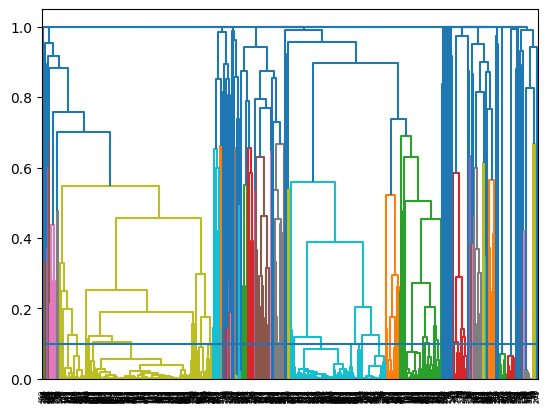


Processing category: Lipid
Original data size: (258, 6)
Data size after removing metadata: (258, 2)
Data size after cleaning: (258, 2)
R2-------------------------------------------
                                         Cells_Children_LargeBODIPYObjects_Count  \
Cells_Children_LargeBODIPYObjects_Count                                 1.000000   
Cells_Children_SmallBODIPYObjects_Count                                 0.381613   

                                         Cells_Children_SmallBODIPYObjects_Count  
Cells_Children_LargeBODIPYObjects_Count                                 0.381613  
Cells_Children_SmallBODIPYObjects_Count                                 1.000000  
cormat-------------------------------------------
[[1.         0.38161251]
 [0.38161251 1.        ]]
dm-------------------------------------------
[[0.         0.61838749]
 [0.61838749 0.        ]]
dm-------------------------------------------
[0.61838749]
linkage_matrix-------------------------------------------
[

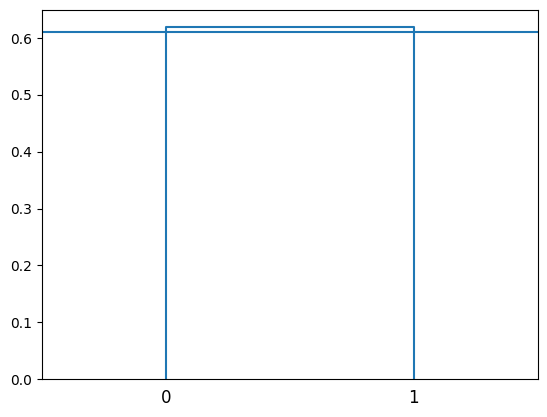


Processing category: AGP
Original data size: (258, 619)
Data size after removing metadata: (258, 615)
Data size after cleaning: (258, 604)
R2-------------------------------------------
                                       Cells_Correlation_Correlation_DNA_AGP  \
Cells_Correlation_Correlation_DNA_AGP                               1.000000   
Cells_Correlation_Correlation_ER_AGP                                0.261961   
Cells_Granularity_10_AGP                                            0.458065   
Cells_Granularity_11_AGP                                            0.265537   
Cells_Granularity_12_AGP                                            0.102775   
...                                                                      ...   
Nuclei_Texture_Variance_AGP_20_03                                   0.000978   
Nuclei_Texture_Variance_AGP_5_00                                    0.063631   
Nuclei_Texture_Variance_AGP_5_01                                    0.066229   
Nuclei_Texture

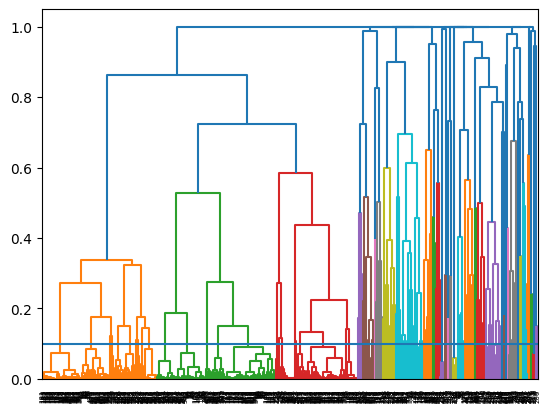


Processing category: DNA
Original data size: (258, 587)
Data size after removing metadata: (258, 583)
Data size after cleaning: (258, 556)
R2-------------------------------------------
                                             Cells_Correlation_Correlation_DNA_ER  \
Cells_Correlation_Correlation_DNA_ER                                     1.000000   
Cells_Intensity_IntegratedIntensityEdge_DNA                              0.121726   
Cells_Intensity_IntegratedIntensity_DNA                                  0.166442   
Cells_Intensity_LowerQuartileIntensity_DNA                               0.000016   
Cells_Intensity_MADIntensity_DNA                                         0.133806   
...                                                                           ...   
Nuclei_Texture_Variance_DNA_20_01                                        0.379165   
Nuclei_Texture_Variance_DNA_20_02                                        0.357841   
Nuclei_Texture_Variance_DNA_5_00                 

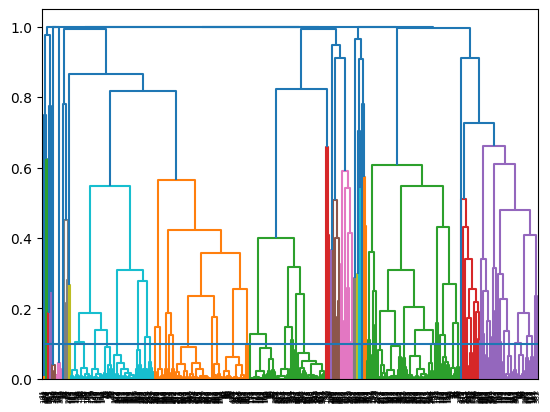


Processing category: Mito
Original data size: (258, 628)
Data size after removing metadata: (258, 624)
Data size after cleaning: (258, 547)
R2-------------------------------------------
                                        Cells_Correlation_Correlation_DNA_Mito  \
Cells_Correlation_Correlation_DNA_Mito                                1.000000   
Cells_Correlation_Correlation_Mito_AGP                                0.575062   
Cells_Correlation_Correlation_Mito_ER                                 0.424031   
Cells_Granularity_10_Mito                                             0.461871   
Cells_Granularity_11_Mito                                             0.276552   
...                                                                        ...   
Nuclei_Texture_Variance_Mito_20_03                                    0.284104   
Nuclei_Texture_Variance_Mito_5_00                                     0.337354   
Nuclei_Texture_Variance_Mito_5_01                                     0.337

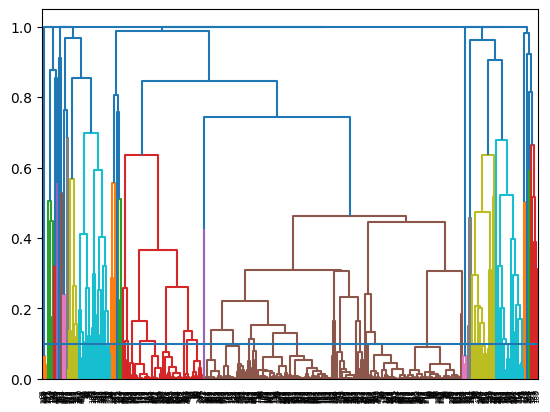

In [93]:
reduced_data_list = []
cluster_info_list = []
for category in features_df['feature_channel'].unique():
    
        # # Generate dendrogram file path
    dendofile = os.path.join(output_path, f"{category}_dendo.pdf")
        # Save cluster information
    clusterfile = os.path.join(output_path, f"{category}_clusters.csv")


    
    print(f"\nProcessing category: {category}")
    category_features = features_df[features_df['feature_channel'] == category]['features'].tolist()
    
    # Subset data to metadata and category features
    sub_lpdf = lpdf[list(metadata_columns) + category_features]
    
    if len(category_features) == 0:
        print(f"No features found for category {category}. Skipping...")
        continue
    if sub_lpdf.shape[1] <= len(metadata_columns) + 1:
        print(f"Not enough features in category {category} for processing. Skipping...")
        continue

    # Clean data
    sub_lpdf_cleaned = clean_data(sub_lpdf)
    if sub_lpdf_cleaned.empty or sub_lpdf_cleaned.shape[1] < 2:
        print(f"Not enough valid features after cleaning in category {category}. Skipping...")
        continue

    # Compute squared correlation matrix
    # R = get_sq_cormatrix(sub_lpdf_cleaned)
    R=sub_lpdf_cleaned.corr()
    R2 = R ** 2
    print("R2-------------------------------------------")
    print(R2)
    cormat = R2.to_numpy()
    print("cormat-------------------------------------------")
    print(cormat)

    dm = 1 - cormat 
    print("dm-------------------------------------------")
    print(dm)
    dm = np.concatenate([row[i+1:] for i, row in enumerate(dm)])
    print("dm-------------------------------------------")
    print(dm)
    # # Compute distance matrix and linkage
    linkage_matrix = linkage(dm, method='complete')
    print("linkage_matrix-------------------------------------------")
    print(linkage_matrix)



    # # Get optimum clusters
    cluster = get_optimum_clusters(R2,linkage_matrix,dendofile)


    # # Create cluster DataFrame
    df_cluster=pd.DataFrame(list(zip(R2.columns.to_list(),cluster)),columns=["Feature","clusternum"])
    df_cluster['cluster_name'] = df_cluster.groupby('clusternum')['Feature'].transform('first')


    df_cluster.to_csv(clusterfile, index=False)
    cluster_info_list.append(df_cluster)

    # Prepare data for reduction
    lpdata = sub_lpdf_cleaned.T.reset_index().rename(columns={'index': 'Feature'})
    merged_df = pd.merge(df_cluster, lpdata, on='Feature', how='inner')

    # Exclude non-numeric columns before computing median
    numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != 'clusternum']

    # Compute median per cluster
    median_df = merged_df.groupby('clusternum')[numeric_cols].median().reset_index()

    # Prepare reduced DataFrame
    cluster_names_df = merged_df[['clusternum', 'cluster_name']].drop_duplicates()
    df_reduced = pd.merge(cluster_names_df, median_df, on='clusternum')
    colnames = df_reduced['cluster_name'].tolist()
    df_reduced = df_reduced.drop(columns=['clusternum', 'cluster_name']).T
    df_reduced.columns = colnames
    df_reduced.index = sub_lpdf_cleaned.index

    # Append reduced data to list
    reduced_data_list.append(df_reduced.reset_index(drop=True))


In [95]:
print(lpdf['Cells_AreaShape_Zernike_6_2'].dtype)

float64


## Test

In [247]:
df_cluster['Feature']=='Cells_AreaShape_Zernike_6_2'

0      False
1      False
2      False
3      False
4      False
       ...  
162    False
163    False
164    False
165    False
166    False
Name: Feature, Length: 167, dtype: bool

In [267]:
print(merged_df.dtypes)

Feature          object
clusternum        int32
cluster_name     object
0               float64
1               float64
                 ...   
2864            float64
2865            float64
2866            float64
2867            float64
2868            float64
Length: 2872, dtype: object


In [97]:
merged_df

,Feature,clusternum,cluster_name,0,1,2,3,4,5,6,...,248,249,250,251,252,253,254,255,256,257
0,Cells_Correlation_Correlation_DNA_Mito,30,Cells_Correlation_Correlation_DNA_Mito,-0.170205,-0.025780,-0.348863,-0.499941,-0.154287,-0.496173,-0.571616,...,-0.138523,-0.081600,-0.607832,-0.313187,-1.102774,-0.306320,0.011598,-0.160119,-0.232624,0.209132
1,Cells_Correlation_Correlation_Mito_AGP,14,Cells_Correlation_Correlation_Mito_AGP,-0.245988,0.740176,0.332040,0.216341,0.291853,0.190174,-0.247392,...,0.544494,-0.857258,-0.496583,-1.367353,-0.700527,-1.106522,-0.836252,0.682982,-0.364383,0.255900
2,Cells_Correlation_Correlation_Mito_ER,67,Cells_Correlation_Correlation_Mito_ER,-0.192432,-0.127021,-0.632079,-0.648506,-0.520266,-0.836751,-0.350269,...,-1.017356,0.227066,-1.063008,-0.685369,-1.382835,-0.773195,0.663855,1.230112,0.828128,1.491951
3,Cells_Granularity_10_Mito,35,Cells_Granularity_10_Mito,-0.878122,-0.647526,-0.230567,-0.579320,-0.618078,-0.635466,-0.558945,...,-0.618082,-0.848157,-0.858152,-0.696781,-0.456400,-0.823867,0.997155,0.402346,0.667556,0.339842
4,Cells_Granularity_11_Mito,53,Cells_Granularity_11_Mito,-0.764970,-0.751522,-0.575453,-0.482946,-0.669724,-0.709056,-0.765117,...,-0.743576,-0.666861,-0.763809,-0.722520,-0.735752,-0.766060,1.601554,0.886429,1.747736,-0.269721
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
542,Nuclei_Texture_Variance_Mito_20_03,63,Nuclei_Intensity_MADIntensity_Mito,-0.390875,-0.428567,-0.377888,-0.440335,-0.451043,-0.370726,-0.392473,...,-0.401996,-0.355627,-0.388656,-0.414498,-0.455411,-0.414458,0.519026,0.598169,0.415579,-0.017039
543,Nuclei_Texture_Variance_Mito_5_00,63,Nuclei_Intensity_MADIntensity_Mito,-0.341555,-0.358187,-0.337720,-0.369491,-0.380894,-0.329312,-0.349885,...,-0.349411,-0.318073,-0.340027,-0.353905,-0.380114,-0.349601,0.331353,0.210472,0.184398,-0.082791
544,Nuclei_Texture_Variance_Mito_5_01,63,Nuclei_Intensity_MADIntensity_Mito,-0.339472,-0.354911,-0.332614,-0.366406,-0.378326,-0.326788,-0.345685,...,-0.348219,-0.317224,-0.338285,-0.350719,-0.376741,-0.344470,0.317824,0.223557,0.171237,-0.091082
545,Nuclei_Texture_Variance_Mito_5_02,63,Nuclei_Intensity_MADIntensity_Mito,-0.348622,-0.363608,-0.339711,-0.375270,-0.387138,-0.334114,-0.354793,...,-0.354331,-0.322695,-0.344473,-0.359448,-0.385830,-0.356440,0.323293,0.232906,0.190129,-0.075213


In [37]:
print(median_df.dtypes)

clusternum      int32
0             float64
1             float64
2             float64
3             float64
               ...   
2864          float64
2865          float64
2866          float64
2867          float64
2868          float64
Length: 2870, dtype: object


In [39]:
sub_lpdf

,Metadata_plate_map_name,Metadata_target,Metadata_sgRNA,Metadata_control_type,Metadata_Plate,Metadata_Well,Metadata_Site_Count,Metadata_Count_Cells,Metadata_Count_Cytoplasm,Metadata_Count_CytoplasmExpandedNuclei,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_20_00_256,Nuclei_Texture_Variance_RNA_20_01_256,Nuclei_Texture_Variance_RNA_20_02_256,Nuclei_Texture_Variance_RNA_20_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,Assay Plate_1_1__2024-06-03T10_54_33-Measureme...,ZNF664,BRDN0008061426,NaN,Assay_Plate_1_1_78,B03,9,1423,1423,1423,...,0.090104,0.090982,0.038449,-0.165871,0.006115,-0.254317,-0.015726,0.027959,-0.013105,0.046318
1,Assay Plate_1_1__2024-06-03T10_54_33-Measureme...,CONTROL repeat,BRDN0008060788,negcon,Assay_Plate_1_1_78,B04,9,1403,1403,1403,...,0.505597,0.573306,0.654539,0.599243,0.519545,0.820918,0.579495,0.521546,0.541670,0.553851
2,Assay Plate_1_1__2024-06-03T10_54_33-Measureme...,UBE2E2,BRDN0008061456,NaN,Assay_Plate_1_1_78,B05,9,1271,1271,1271,...,1.126189,1.162336,1.140302,1.286133,1.169231,1.226514,1.165777,1.099416,1.141977,1.165777
3,Assay Plate_1_1__2024-06-03T10_54_33-Measureme...,HSD17B12,BRDN0008063065,NaN,Assay_Plate_1_1_78,B06,9,1333,1333,1333,...,0.489776,0.481912,0.603430,0.392493,0.439170,0.366206,0.448811,0.462379,0.448811,0.475055
4,Assay Plate_1_1__2024-06-03T10_54_33-Measureme...,UBE2E2,BRDN0008061459,NaN,Assay_Plate_1_1_78,B07,9,1351,1351,1351,...,0.929859,0.894108,0.973835,0.638389,0.935257,0.878580,0.903266,0.900641,0.891505,0.944770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,BR10044673,OTULIN,BRDN0008062146,NaN,BR00144673,M12,9,1374,1374,1374,...,-0.987969,-0.987969,-1.083566,-1.039072,-1.009547,-1.037574,-0.993678,-1.006643,-0.989393,-0.996544
2865,BR10044673,FLI1,BRDN0008062176,NaN,BR00144673,M13,9,1567,1567,1567,...,-0.669768,-0.732323,-0.624526,-0.481912,-0.642679,-0.795486,-0.639461,-0.659960,-0.646981,-0.665401
2866,BR10044673,PIK3CA,BRDN0008060828,NaN,BR00144673,M14,9,1356,1356,1356,...,-0.367141,-0.384015,-0.352229,-0.232719,-0.296057,-0.458494,-0.375565,-0.364339,-0.366206,-0.390607
2867,BR10044673,MOV10L1,BRDN0008062159,NaN,BR00144673,M16,9,1652,1652,1652,...,-2.244002,-2.254970,-2.155718,-1.735303,-2.173914,-1.985060,-2.202635,-2.244002,-2.202635,-2.233298


In [41]:
features_df

,features,feature_channel
0,Cells_AreaShape_Area,Compartimental
1,Cells_AreaShape_Compactness,Compartimental
2,Cells_AreaShape_ConvexArea,Compartimental
3,Cells_AreaShape_Eccentricity,Compartimental
4,Cells_AreaShape_EquivalentDiameter,Compartimental
...,...,...
4232,Nuclei_Texture_Variance_RNA_20_03_256,RNA
4233,Nuclei_Texture_Variance_RNA_5_00_256,RNA
4234,Nuclei_Texture_Variance_RNA_5_01_256,RNA
4235,Nuclei_Texture_Variance_RNA_5_02_256,RNA


In [44]:
cormat.shape

(597, 597)

In [99]:
features_df

,features,feature_channel
0,Cells_AreaShape_Area,Compartimental
1,Cells_AreaShape_Center_X,Compartimental
2,Cells_AreaShape_Center_Y,Compartimental
3,Cells_AreaShape_Compactness,Compartimental
4,Cells_AreaShape_Eccentricity,Compartimental
...,...,...
2595,Cytoplasm_Texture_Variance_Mito_20_03,Mito
2596,Cytoplasm_Texture_Variance_Mito_5_00,Mito
2597,Cytoplasm_Texture_Variance_Mito_5_01,Mito
2598,Cytoplasm_Texture_Variance_Mito_5_02,Mito
